In [ ]:
import pandas as pd
import os
from glob import glob

In [ ]:


# File paths
clinical_file = r"D:\mlpr data\Glioblastoma-ML-model\UPENN-GBM_clinical_info_v2.1.csv"
radiomics_folder = r"D:\mlpr data\radiomic_features_CaPTk"

# Load clinical data
clinical_df = pd.read_csv(clinical_file)
clinical_df.rename(columns={"ID": "PatientID"}, inplace=True)  # Standardizing ID column name

# Load all radiomic CSVs and merge horizontally on PatientID
radiomic_files = glob(os.path.join(radiomics_folder, "*.csv"))

# Initialize empty dataframe for radiomics
radiomics_df = pd.DataFrame()

for file in radiomic_files:
    df = pd.read_csv(file)
    df.rename(columns={"SubjectID": "PatientID"}, inplace=True)  # Standardizing ID column name
    
    # Merge radiomics files horizontally
    if radiomics_df.empty:
        radiomics_df = df
    else:
        radiomics_df = pd.merge(radiomics_df, df, on="PatientID", how="outer")

# Merge clinical data with radiomics data
merged_df = pd.merge(clinical_df, radiomics_df, on="PatientID", how="outer")

# Save final merged dataset
output_file = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
merged_df.to_csv(output_file, index=False)

print(f"Merged dataset saved at {output_file}")


Merged dataset saved at D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric (forcing errors='coerce' turns non-numeric values into NaN)
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED"])  # Drop ID and target
y = df["Survival_from_surgery_days_UPDATED"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoder for future use

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric
X = X.fillna(X.median())  # Replace NaNs with median

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

C:\Users\asp61\AppData\Local\Temp\ipykernel_18804\2365178571.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [2]:
df.shape

(644, 9516)

In [3]:

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  # Use all cores
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
evs = explained_variance_score(y_test, y_pred)  # Explained Variance Score

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Explained Variance Score: {evs:.4f}")


Mean Absolute Error: 342.39
R² Score: 0.0764
Root Mean Squared Error (RMSE): 475.31
Explained Variance Score: 0.0794


## Classifier

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric (handling non-numeric values)
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# **Convert Survival Days into Categories (Example Binning)**
# You can modify bins as per your requirement
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25,50, 75])  
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]  
labels = [0, 1, 2, 3]  # Adjust as needed
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoders for future use

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric
X = X.fillna(X.median())  # Replace NaNs with median

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

C:\Users\asp61\AppData\Local\Temp\ipykernel_18804\2159967707.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Accuracy: 0.30
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.39      0.43        33
           1       0.30      0.19      0.23        32
           2       0.24      0.31      0.27        32
           3       0.25      0.31      0.28        32

    accuracy                           0.30       129
   macro avg       0.32      0.30      0.30       129
weighted avg       0.32      0.30      0.30       129



In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric (handling non-numeric values)
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25,50, 75])  
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]  
labels = [0, 1, 2, 3]  # Adjust as needed
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoders for future use

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric
X = X.fillna(X.median())  # Replace NaNs with median

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.9)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# Print the number of PCA components
print(f"Number of PCA components used: {X_pca.shape[1]}")

C:\Users\asp61\AppData\Local\Temp\ipykernel_18804\571684290.py:11: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Accuracy: 0.32
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.42      0.41        33
           1       0.31      0.25      0.28        32
           2       0.29      0.28      0.29        32
           3       0.28      0.31      0.29        32

    accuracy                           0.32       129
   macro avg       0.32      0.32      0.32       129
weighted avg       0.32      0.32      0.32       129

Number of PCA components used: 182


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]
labels = [0, 1, 2]  

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using RandomForest
selector = SelectFromModel(RandomForestClassifier(n_estimators=150, random_state=42), max_features=100)
X_selected = selector.fit_transform(X_scaled, y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Balance Classes with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Base Models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(max_iter=1000)

# Voting Classifier (Soft Voting for Probabilistic Averaging)
ensemble_model_1 = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg)],
    voting="soft"  # Example of weight assignment
)
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg)],
    final_estimator=RandomForestClassifier()
)
stacking_clf.fit(X_train, y_train)

# Train Ensemble Model
ensemble_model_1.fit(X_train, y_train)

# Predictions
y_pred = ensemble_model_1.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
report = classification_report(y_test, y_pred)
report_stacking = classification_report(y_test, y_pred_stacking)

print(f"Ensemble Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

print(f"Stacking Model Accuracy: {accuracy_stacking:.2f}")
print("Classification Report:\n", report_stacking)

C:\Users\asp61\AppData\Local\Temp\ipykernel_19192\3966034821.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Ensemble Model Accuracy: 0.53
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55        43
           1       0.40      0.33      0.36        42
           2       0.67      0.64      0.65        44

    accuracy                           0.53       129
   macro avg       0.52      0.52      0.52       129
weighted avg       0.52      0.53      0.52       129

Stacking Model Accuracy: 0.44
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.53      0.51        43
           1       0.36      0.36      0.36        42
           2       0.49      0.43      0.46        44

    accuracy                           0.44       129
   macro avg       0.44      0.44      0.44       129
weighted avg       0.44      0.44      0.44       129



In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import xgboost as xgb

class AdvancedEnsembleClassifier:
    def __init__(self, file_path):
        # Load data
        self.df = pd.read_csv(file_path)
        self.prepare_data()
    
    def prepare_data(self):
        # Convert target column to numeric
        self.df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(
            self.df["Survival_from_surgery_days_UPDATED"], 
            errors="coerce"
        )

        # Drop rows where target variable is NaN
        self.df = self.df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

        # Percentile-Based Binning with adjustment
        percentiles = np.percentile(self.df["Survival_from_surgery_days_UPDATED"], [33,66])
        bins = [0, percentiles[0], percentiles[1], np.inf]
        print("Percentiles for Binning:", percentiles)
        labels = [0, 1, 2]  

        self.df["Survival_Category"] = pd.cut(
            self.df["Survival_from_surgery_days_UPDATED"], 
            bins=bins, 
            labels=labels
        )

        # Separate features (X) and target (y)
        X = self.df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
        y = self.df["Survival_Category"].astype(int)

        # Encode categorical columns
        categorical_cols = X.select_dtypes(include=["object"]).columns
        self.label_encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le

        # Fill missing numeric values with median
        X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

        # Standardize numeric features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # Feature Selection
        self.selector = SelectKBest(score_func=f_classif, k=50)
        X_selected = self.selector.fit_transform(X_scaled, y)

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_selected, y, 
            test_size=0.2, 
            random_state=42, 
            stratify=y
        )

        # Apply SMOTE for class balancing
        smote = SMOTE(random_state=42)
        self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)
    
    def create_models(self):
        # Base models with improved parameters
        rf_clf = RandomForestClassifier(
            n_estimators=300, 
            max_depth=10, 
            min_samples_split=5, 
            min_samples_leaf=2, 
            random_state=42
        )
        
        xgb_clf = xgb.XGBClassifier(
            n_estimators=250, 
            learning_rate=0.05, 
            max_depth=40, 
            random_state=42
        )
        
        svm_clf = SVC(
            kernel='rbf', 
            probability=True, 
            C=1.0, 
            random_state=42
        )
        
        # Stacking Classifier with multiple base models
        stacking_clf = StackingClassifier(
            estimators=[
                ('rf', rf_clf),
                ('xgb', xgb_clf),
                ('svm', svm_clf)
            ],
            final_estimator=LogisticRegression(max_iter=1000),
            cv=5
        )
        
        return stacking_clf
    
    def train_and_evaluate(self):
        # Create and train the model
        model = self.create_models()
        model.fit(self.X_train, self.y_train)
        
        # Predictions
        y_pred = model.predict(self.X_test)
        
        # Detailed evaluation
        print("Confusion Matrix:")
        print(confusion_matrix(self.y_test, y_pred))
        
        print("\nDetailed Classification Report:")
        print(classification_report(self.y_test, y_pred))
        
        # Cross-validation
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5)
        print("\nCross-Validation Scores:", cv_scores)
        print("Mean CV Score:", cv_scores.mean())
        
        return model

def main():
    file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
    ensemble = AdvancedEnsembleClassifier(file_path)
    model = ensemble.train_and_evaluate()

if __name__ == "__main__":
    main()

C:\Users\asp61\AppData\Local\Temp\ipykernel_18804\3205822300.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(file_path)


Percentiles for Binning: [234.   506.52]


c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [   2    3   69   74   80  103  104  105  107  108  110  213  218  224
  247  248  249  251  252  254  357  362  368  391  392  393  501  506
  512  535  536  537  539  540  542  645  650  656  679  680  681  683
  684  686  789  794  800  823  824  825  933  938  944  967  968  969
  971  972  974 1077 1082 1088 1111 1112 1113 1115 1116 1118 1221 1226
 1232 1255 1256 1257 1365 1370 1376 1399 1400 1401 1403 1404 1406 1509
 1514 1520 1543 1544 1545 1547 1548 1550 1653 1658 1664 1687 1688 1689
 1797 1802 1808 1831 1832 1833 1835 1836 1838 1941 1946 1952 1975 1976
 1977 1979 1980 1982 2085 2090 2096 2119 2120 2121 2229 2234 2240 2263
 2264 2265 2267 2268 2270 2373 2378 2384 2407 2408 2409 2411 2412 2414
 2517 2522 2528 2551 2552 2553 2661 2666 2672 2695 2696 2697 2699 2700
 2702 2805 2810 2816 2839 2840 2841 2843 2844 2846 2949 2954 2960 29

Confusion Matrix:
[[31  7  5]
 [18  6 18]
 [ 5 11 28]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.72      0.64        43
           1       0.25      0.14      0.18        42
           2       0.55      0.64      0.59        44

    accuracy                           0.50       129
   macro avg       0.46      0.50      0.47       129
weighted avg       0.46      0.50      0.47       129


Cross-Validation Scores: [0.46666667 0.4952381  0.48571429 0.4952381  0.53333333]
Mean CV Score: 0.49523809523809526


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Target processing
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Binning the target
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]
labels = [0, 1, 2]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Features and target
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical variables
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill and scale
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection
selector = SelectFromModel(RandomForestClassifier(n_estimators=150, random_state=42), max_features=100)
X_selected = selector.fit_transform(X_scaled, y)

# Split and balance
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define base models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
log_reg = LogisticRegression(max_iter=1000)
svm_clf = SVC(probability=True, kernel="rbf", C=1.0, gamma="scale")

# Voting Classifier (soft voting)
ensemble_model_2 = VotingClassifier(
    estimators=[
        ("RandomForest", rf_clf),
        ("XGBoost", xgb_clf),
        ("LogReg", log_reg),
        ("SVM", svm_clf)
    ],
    voting="soft"
)

# Stacking Classifier
stacking_clf_2 = StackingClassifier(
    estimators=[
        ("RandomForest", rf_clf),
        ("XGBoost", xgb_clf),
        ("LogReg", log_reg),
        ("SVM", svm_clf)
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)

# Train models
ensemble_model_2.fit(X_train, y_train)
stacking_clf_2.fit(X_train, y_train)

# Evaluate models
y_pred = ensemble_model_2.predict(X_test)
y_pred_stacking = stacking_clf_2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

report = classification_report(y_test, y_pred)
report_stacking = classification_report(y_test, y_pred_stacking)

print(f"\nEnsemble (Voting) Accuracy: {accuracy:.2f}")
print("Voting Classification Report:\n", report)

print(f"\nStacking Accuracy: {accuracy_stacking:.2f}")
print("Stacking Classification Report:\n", report_stacking)


C:\Users\asp61\AppData\Local\Temp\ipykernel_19192\770886090.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:34:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarnin


Ensemble (Voting) Accuracy: 0.54
Voting Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.63      0.56        43
           1       0.43      0.36      0.39        42
           2       0.70      0.64      0.67        44

    accuracy                           0.54       129
   macro avg       0.54      0.54      0.54       129
weighted avg       0.54      0.54      0.54       129


Stacking Accuracy: 0.48
Stacking Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.58      0.55        43
           1       0.36      0.31      0.33        42
           2       0.53      0.55      0.54        44

    accuracy                           0.48       129
   macro avg       0.47      0.48      0.47       129
weighted avg       0.47      0.48      0.48       129



In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Load the dataset
# Replace with your actual file path
file_path =  r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning - fixed the bins issue
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]  # Corrected bins definition
labels = [0, 1, 2]  

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Train-test split (80:20) - Do this before scaling to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a preprocessing pipeline with scaling and feature selection
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectFromModel(
        GradientBoostingClassifier(n_estimators=100, random_state=42), 
        max_features=50)  # Reduced from 100 to 50 features
    )
])

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42, k_neighbors=5)  # Specify k_neighbors for better results
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define Base Models with tuned hyperparameters
rf_clf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

xgb_clf = xgb.XGBClassifier(
    n_estimators=150, 
    learning_rate=0.1, 
    max_depth=5, 
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

log_reg = LogisticRegression(
    C=0.5,
    solver='liblinear',
    max_iter=2000,
    random_state=42
)

knn_clf = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance'
)

svm_clf = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42
)

# Voting Classifier with adjusted weights
ensemble_model = VotingClassifier(
    estimators=[
        ("RandomForest", rf_clf), 
        ("XGBoost", xgb_clf), 
        ("LogReg", log_reg),
        ("KNN", knn_clf),
        ("SVM", svm_clf)
    ],
    voting="soft", 
    weights=[2, 2, 1, 1, 1.5]  # Adjusted weights
)

# Stacking Classifier with a different meta-learner
stacking_clf = StackingClassifier(
    estimators=[
        ("RandomForest", rf_clf), 
        ("XGBoost", xgb_clf), 
        ("LogReg", log_reg),
        ("KNN", knn_clf)
    ],
    final_estimator=GradientBoostingClassifier(n_estimators=100, random_state=42),
    cv=5  # 5-fold cross-validation
)

# Train models
ensemble_model.fit(X_train_resampled, y_train_resampled)
stacking_clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_ensemble = ensemble_model.predict(X_test_processed)
y_pred_stacking = stacking_clf.predict(X_test_processed)

# Evaluate models
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)

print(f"Ensemble Model Accuracy: {accuracy_ensemble:.2f}")
print("Classification Report (Ensemble):\n", classification_report(y_test, y_pred_ensemble))

print(f"Stacking Model Accuracy: {accuracy_stacking:.2f}")
print("Classification Report (Stacking):\n", classification_report(y_test, y_pred_stacking))

C:\Users\asp61\AppData\Local\Temp\ipykernel_19192\2758369117.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Ensemble Model Accuracy: 0.57
Classification Report (Ensemble):
               precision    recall  f1-score   support

           0       0.50      0.72      0.59        43
           1       0.57      0.31      0.40        42
           2       0.66      0.66      0.66        44

    accuracy                           0.57       129
   macro avg       0.57      0.56      0.55       129
weighted avg       0.58      0.57      0.55       129

Stacking Model Accuracy: 0.44
Classification Report (Stacking):
               precision    recall  f1-score   support

           0       0.46      0.63      0.53        43
           1       0.31      0.29      0.30        42
           2       0.58      0.41      0.48        44

    accuracy                           0.44       129
   macro avg       0.45      0.44      0.44       129
weighted avg       0.45      0.44      0.44       129



c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-09 13:42:42,025] A new study created in memory with name: no-name-db42d963-5cb5-437f-b4d4-c1dab7ff1308


Optimizing Ensemble Model...


[I 2025-04-09 13:42:43,621] Trial 0 finished with value: 0.9524198078256308 and parameters: {'rf_n_estimators': 195, 'rf_max_depth': 9, 'rf_min_samples_split': 3, 'xgb_n_estimators': 81, 'xgb_learning_rate': 0.012624668075432121, 'xgb_max_depth': 10, 'xgb_subsample': 0.943592368284729, 'xgb_colsample_bytree': 0.8578348706209307, 'log_reg_C': 0.03392751113421898, 'log_reg_solver': 'lbfgs'}. Best is trial 0 with value: 0.9524198078256308.
[I 2025-04-09 13:42:45,176] Trial 1 finished with value: 0.9485430242318662 and parameters: {'rf_n_estimators': 280, 'rf_max_depth': 12, 'rf_min_samples_split': 14, 'xgb_n_estimators': 83, 'xgb_learning_rate': 0.10716866082486512, 'xgb_max_depth': 4, 'xgb_subsample': 0.6476011172100687, 'xgb_colsample_bytree': 0.8064298718394076, 'log_reg_C': 0.5350465072659588, 'log_reg_solver': 'lbfgs'}. Best is trial 0 with value: 0.9524198078256308.
[I 2025-04-09 13:42:45,995] Trial 2 finished with value: 0.9446291615207899 and parameters: {'rf_n_estimators': 55, 'r

Best trial for Ensemble Model:
  Value: 0.9543
  Params: 
    rf_n_estimators: 124
    rf_max_depth: 8
    rf_min_samples_split: 2
    xgb_n_estimators: 227
    xgb_learning_rate: 0.02411785491398546
    xgb_max_depth: 10
    xgb_subsample: 0.9173229807998943
    xgb_colsample_bytree: 0.9809914380784289
    log_reg_C: 0.03053110065048662
    log_reg_solver: liblinear

Optimizing Stacking Model...


[I 2025-04-09 13:45:16,656] Trial 0 finished with value: 0.942759737669679 and parameters: {'rf_n_estimators': 209, 'rf_max_depth': 6, 'rf_min_samples_split': 10, 'xgb_n_estimators': 191, 'xgb_learning_rate': 0.02961989390589191, 'xgb_max_depth': 4, 'xgb_subsample': 0.9856293225624563, 'xgb_colsample_bytree': 0.6674659637252496, 'log_reg_C': 0.07368528440631428, 'log_reg_solver': 'saga', 'final_rf_n_estimators': 217, 'final_rf_max_depth': 17}. Best is trial 0 with value: 0.942759737669679.
[I 2025-04-09 13:45:40,240] Trial 1 finished with value: 0.9462833429306396 and parameters: {'rf_n_estimators': 262, 'rf_max_depth': 13, 'rf_min_samples_split': 19, 'xgb_n_estimators': 215, 'xgb_learning_rate': 0.11680441378112139, 'xgb_max_depth': 5, 'xgb_subsample': 0.6074470882013117, 'xgb_colsample_bytree': 0.8467693021750542, 'log_reg_C': 7.336936649399507, 'log_reg_solver': 'lbfgs', 'final_rf_n_estimators': 175, 'final_rf_max_depth': 12}. Best is trial 1 with value: 0.9462833429306396.
[I 2025-

Best trial for Stacking Model:
  Value: 0.9523
  Params: 
    rf_n_estimators: 119
    rf_max_depth: 11
    rf_min_samples_split: 6
    xgb_n_estimators: 283
    xgb_learning_rate: 0.05667861791180091
    xgb_max_depth: 4
    xgb_subsample: 0.9387405750570498
    xgb_colsample_bytree: 0.7345058855020331
    log_reg_C: 0.05437529681006572
    log_reg_solver: lbfgs
    final_rf_n_estimators: 248
    final_rf_max_depth: 17

Training best models...

Best Ensemble Model Accuracy with LDA: 0.9767
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.94      0.97      0.95        32
           2       1.00      0.97      0.98        32
           3       1.00      1.00      1.00        32

    accuracy                           0.98       129
   macro avg       0.98      0.98      0.98       129
weighted avg       0.98      0.98      0.98       129


Best Stacking Model Accuracy with LDA: 0.961

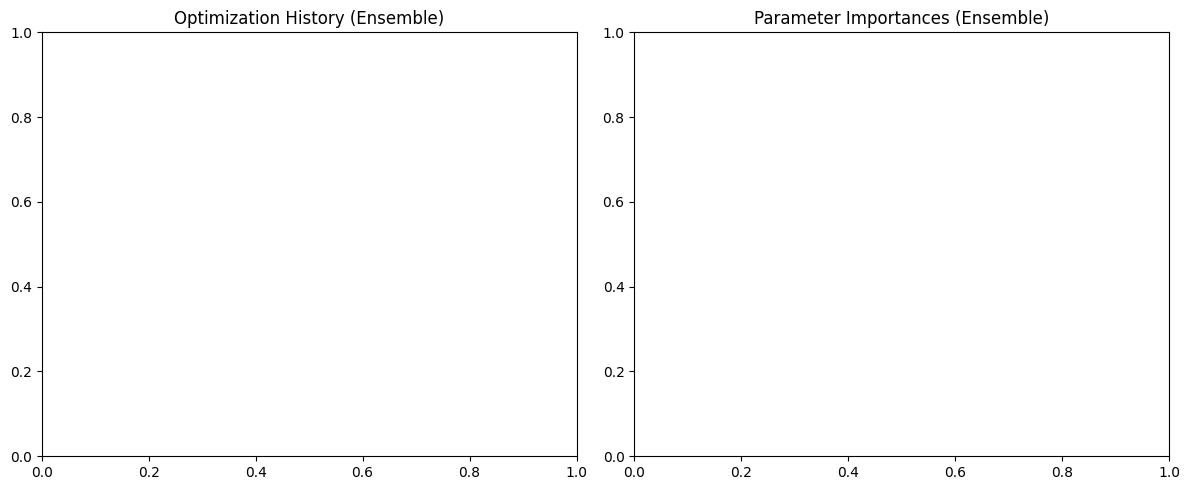

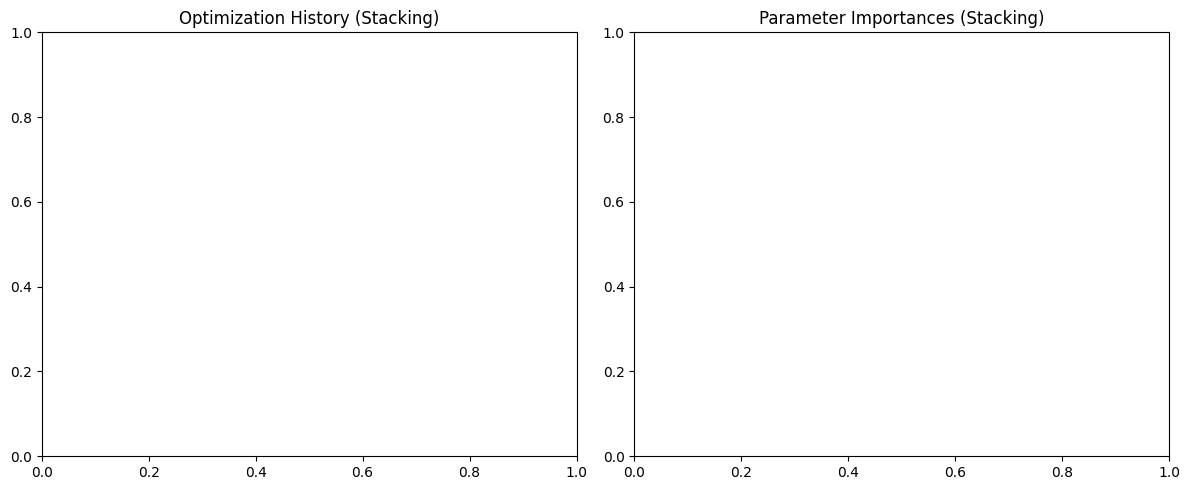

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25, 50, 75])
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]
labels = [0, 1, 2, 3]

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=3)  # Adjust components based on the number of classes - 1
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)

# Balance Classes with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define the objective function for Optuna (Ensemble Model)
def objective_ensemble(trial):
    # Hyperparameters for Random Forest
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 3, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
    
    # Hyperparameters for XGBoost
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
    xgb_subsample = trial.suggest_float('xgb_subsample', 0.6, 1.0)
    xgb_colsample_bytree = trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
    
    # Hyperparameters for Logistic Regression
    log_reg_C = trial.suggest_float('log_reg_C', 0.01, 10.0, log=True)
    log_reg_solver = trial.suggest_categorical('log_reg_solver', ['lbfgs', 'liblinear', 'saga'])
    
    # Define models with the suggested hyperparameters
    rf_clf = RandomForestClassifier(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        random_state=42
    )
    
    xgb_clf = xgb.XGBClassifier(
        n_estimators=xgb_n_estimators,
        learning_rate=xgb_learning_rate,
        max_depth=xgb_max_depth,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        random_state=42
    )
    
    log_reg = LogisticRegression(
        C=log_reg_C,
        solver=log_reg_solver,
        max_iter=1000,
        random_state=42
    )
    
    lda_clf = LinearDiscriminantAnalysis()
    
    # Create the ensemble model
    ensemble_model = VotingClassifier(
        estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
        voting="soft"
    )
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        ensemble_model.fit(X_train_fold, y_train_fold)
        y_pred = ensemble_model.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred, average='weighted')
        scores.append(score)
    
    return np.mean(scores)

# Define the objective function for Optuna (Stacking Model)
def objective_stacking(trial):
    # Hyperparameters for Random Forest
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 300)
    rf_max_depth = trial.suggest_int('rf_max_depth', 3, 20)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 20)
    
    # Hyperparameters for XGBoost
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 300)
    xgb_learning_rate = trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True)
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 3, 10)
    xgb_subsample = trial.suggest_float('xgb_subsample', 0.6, 1.0)
    xgb_colsample_bytree = trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0)
    
    # Hyperparameters for Logistic Regression
    log_reg_C = trial.suggest_float('log_reg_C', 0.01, 10.0, log=True)
    log_reg_solver = trial.suggest_categorical('log_reg_solver', ['lbfgs', 'liblinear', 'saga'])
    
    # Hyperparameters for final estimator (Random Forest)
    final_rf_n_estimators = trial.suggest_int('final_rf_n_estimators', 50, 300)
    final_rf_max_depth = trial.suggest_int('final_rf_max_depth', 3, 20)
    
    # Define models with the suggested hyperparameters
    rf_clf = RandomForestClassifier(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        random_state=42
    )
    
    xgb_clf = xgb.XGBClassifier(
        n_estimators=xgb_n_estimators,
        learning_rate=xgb_learning_rate,
        max_depth=xgb_max_depth,
        subsample=xgb_subsample,
        colsample_bytree=xgb_colsample_bytree,
        random_state=42
    )
    
    log_reg = LogisticRegression(
        C=log_reg_C,
        solver=log_reg_solver,
        max_iter=1000,
        random_state=42
    )
    
    lda_clf = LinearDiscriminantAnalysis()
    
    final_estimator = RandomForestClassifier(
        n_estimators=final_rf_n_estimators,
        max_depth=final_rf_max_depth,
        random_state=42
    )
    
    # Create the stacking model
    stacking_clf = StackingClassifier(
        estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
        final_estimator=final_estimator,
        cv=5
    )
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        stacking_clf.fit(X_train_fold, y_train_fold)
        y_pred = stacking_clf.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred, average='weighted')
        scores.append(score)
    
    return np.mean(scores)

# Run Optuna optimization for Ensemble Model
print("Optimizing Ensemble Model...")
study_ensemble = optuna.create_study(direction='maximize')
study_ensemble.optimize(objective_ensemble, n_trials=50)  # Adjust n_trials as needed

print("Best trial for Ensemble Model:")
print(f"  Value: {study_ensemble.best_value:.4f}")
print("  Params: ")
for key, value in study_ensemble.best_params.items():
    print(f"    {key}: {value}")

# Run Optuna optimization for Stacking Model
print("\nOptimizing Stacking Model...")
study_stacking = optuna.create_study(direction='maximize')
study_stacking.optimize(objective_stacking, n_trials=50)  # Adjust n_trials as needed

print("Best trial for Stacking Model:")
print(f"  Value: {study_stacking.best_value:.4f}")
print("  Params: ")
for key, value in study_stacking.best_params.items():
    print(f"    {key}: {value}")

# Create and train the best Ensemble Model
best_rf_ensemble = RandomForestClassifier(
    n_estimators=study_ensemble.best_params['rf_n_estimators'],
    max_depth=study_ensemble.best_params['rf_max_depth'],
    min_samples_split=study_ensemble.best_params['rf_min_samples_split'],
    random_state=42
)

best_xgb_ensemble = xgb.XGBClassifier(
    n_estimators=study_ensemble.best_params['xgb_n_estimators'],
    learning_rate=study_ensemble.best_params['xgb_learning_rate'],
    max_depth=study_ensemble.best_params['xgb_max_depth'],
    subsample=study_ensemble.best_params['xgb_subsample'],
    colsample_bytree=study_ensemble.best_params['xgb_colsample_bytree'],
    random_state=42
)

best_log_reg_ensemble = LogisticRegression(
    C=study_ensemble.best_params['log_reg_C'],
    solver=study_ensemble.best_params['log_reg_solver'],
    max_iter=1000,
    random_state=42
)

best_lda_ensemble = LinearDiscriminantAnalysis()

best_ensemble_model = VotingClassifier(
    estimators=[
        ("RandomForest", best_rf_ensemble), 
        ("XGBoost", best_xgb_ensemble), 
        ("LogReg", best_log_reg_ensemble), 
        ("LDA", best_lda_ensemble)
    ],
    voting="soft"
)

# Create and train the best Stacking Model
best_rf_stacking = RandomForestClassifier(
    n_estimators=study_stacking.best_params['rf_n_estimators'],
    max_depth=study_stacking.best_params['rf_max_depth'],
    min_samples_split=study_stacking.best_params['rf_min_samples_split'],
    random_state=42
)

best_xgb_stacking = xgb.XGBClassifier(
    n_estimators=study_stacking.best_params['xgb_n_estimators'],
    learning_rate=study_stacking.best_params['xgb_learning_rate'],
    max_depth=study_stacking.best_params['xgb_max_depth'],
    subsample=study_stacking.best_params['xgb_subsample'],
    colsample_bytree=study_stacking.best_params['xgb_colsample_bytree'],
    random_state=42
)

best_log_reg_stacking = LogisticRegression(
    C=study_stacking.best_params['log_reg_C'],
    solver=study_stacking.best_params['log_reg_solver'],
    max_iter=1000,
    random_state=42
)

best_lda_stacking = LinearDiscriminantAnalysis()

best_final_estimator = RandomForestClassifier(
    n_estimators=study_stacking.best_params['final_rf_n_estimators'],
    max_depth=study_stacking.best_params['final_rf_max_depth'],
    random_state=42
)

best_stacking_model = StackingClassifier(
    estimators=[
        ("RandomForest", best_rf_stacking), 
        ("XGBoost", best_xgb_stacking), 
        ("LogReg", best_log_reg_stacking), 
        ("LDA", best_lda_stacking)
    ],
    final_estimator=best_final_estimator,
    cv=5
)

# Train the best models
print("\nTraining best models...")
best_ensemble_model.fit(X_train, y_train)
best_stacking_model.fit(X_train, y_train)

# Evaluate the best models
y_pred_best_ensemble = best_ensemble_model.predict(X_test)
y_pred_best_stacking = best_stacking_model.predict(X_test)

accuracy_best_ensemble = accuracy_score(y_test, y_pred_best_ensemble)
accuracy_best_stacking = accuracy_score(y_test, y_pred_best_stacking)

report_best_ensemble = classification_report(y_test, y_pred_best_ensemble)
report_best_stacking = classification_report(y_test, y_pred_best_stacking)

print(f"\nBest Ensemble Model Accuracy with LDA: {accuracy_best_ensemble:.4f}")
print("Classification Report:\n", report_best_ensemble)

print(f"\nBest Stacking Model Accuracy with LDA: {accuracy_best_stacking:.4f}")
print("Classification Report:\n", report_best_stacking)

# Visualize Optuna results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_optimization_history(study_ensemble)
plt.title("Optimization History (Ensemble)")

plt.subplot(1, 2, 2)
plot_param_importances(study_ensemble)
plt.title("Parameter Importances (Ensemble)")
plt.tight_layout()
plt.savefig('ensemble_optuna_results.png')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_optimization_history(study_stacking)
plt.title("Optimization History (Stacking)")

plt.subplot(1, 2, 2)
plot_param_importances(study_stacking)
plt.title("Parameter Importances (Stacking)")
plt.tight_layout()
plt.savefig('stacking_optuna_results.png')

print("\nOptimization plots saved as 'ensemble_optuna_results.png' and 'stacking_optuna_results.png'")


In [12]:
import joblib

# Save ensemble model
joblib.dump(best_ensemble_model, "best_ensemble_model.pkl")

# Save stacking model
joblib.dump(best_stacking_model, "best_stacking_model.pkl")


['best_stacking_model.pkl']

Best trial for Ensemble Model:
  Value: 0.9543
  Params: 
    rf_n_estimators: 124
    rf_max_depth: 8
    rf_min_samples_split: 2
    xgb_n_estimators: 227
    xgb_learning_rate: 0.02411785491398546
    xgb_max_depth: 10
    xgb_subsample: 0.9173229807998943
    xgb_colsample_bytree: 0.9809914380784289
    log_reg_C: 0.03053110065048662
    log_reg_solver: liblinear